# Causal Inference of Obesity’s Effect on Diabetes Risk Using EconML

## Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from econml.dml import LinearDML, CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML


In [ ]:
# importing and exploring the diabetes dataset
# source: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
df = pd.read_csv('diabetes.csv')
df


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


LinearDML ATE (mean CATE): 0.17


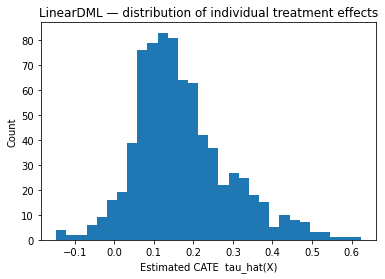

In [6]:
# Define Outcome, Treatment, and Covariates
Y = df["Outcome"].to_numpy().astype(float)

# Example treatment: obesity (BMI > 30)
df["Treatment"] = (df["BMI"] > 30).astype(int)
T = df["Treatment"].to_numpy().astype(int)

# Confounders: all other columns except Outcome and BMI (used in treatment definition)
covars = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
          "Insulin", "DiabetesPedigreeFunction", "Age"]
X = df[covars].to_numpy().astype(float)

# Initialize models LinearDML (ATE and CATE)
model_y = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, random_state=42)
model_t = LogisticRegression(max_iter=2000)

# Setup and fit LinearDML
dml = LinearDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    random_state=42
)
dml.fit(Y, T, X=X)

cate_dml = dml.effect(X)
ate_dml = float(np.mean(cate_dml))
print("LinearDML ATE (mean CATE):", round(ate_dml, 3))

plt.figure()
plt.hist(cate_dml, bins=30)
plt.xlabel("Estimated CATE  tau_hat(X)")
plt.ylabel("Count")
plt.title("LinearDML — distribution of individual treatment effects")
plt.show()

### Interpretation
- 0.17 means that, on average, being obese increases the probability of having diabetes by 17 percentage points relative to not being obese.

- The histogram of cate_dml shows that most conditional treatment effect estimates are positive, concentrated around 0.1–0.3, suggesting the treatment is generally beneficial. However, the distribution is fairly wide, with some negative values and some large positive effects (>0.5), indicating substantial heterogeneity in treatment responses across individuals.

### Heterogeneous Effects by Age, Glucose, and BMI

In [7]:
for group in ["Age", "Glucose", "BMI"]:
    median = np.median(df[group])
    low_idx = df[group] <= median
    high_idx = df[group] > median
    ate_low = np.mean(dml.effect(X[low_idx]))
    ate_high = np.mean(dml.effect(X[high_idx]))
    print(f"{group} ≤ {median}: ATE = {ate_low:.3f}")
    print(f"{group} > {median}: ATE = {ate_high:.3f}")



Age ≤ 29.0: ATE = 0.142
Age > 29.0: ATE = 0.200
Glucose ≤ 117.0: ATE = 0.113
Glucose > 117.0: ATE = 0.230
BMI ≤ 32.0: ATE = 0.172
BMI > 32.0: ATE = 0.169


### Interpretation
- Obesity increases diabetes risk across all groups.
- The effect is stronger in older patients(+20% risk) and in those with higher glucose(+23% risk).
- But BMI itself (within the obese range) doesn’t differentiate much — the key drivers of heterogeneity are age and glucose.

### Final Summary

Our causal analysis using **LinearDML** suggests that **obesity increases the probability of diabetes by about 17 percentage points on average**.

The **distribution of conditional treatment effects (CATEs)** shows that most individuals experience a positive effect of obesity on diabetes risk (typically between 0.10–0.30), though there is **substantial heterogeneity**: some individuals show little or even negative effects, while others face much higher risks (>0.50).

Subgroup analysis reveals that the **obesity effect is consistently harmful across all groups**, but it is **stronger in older patients and in those with elevated glucose levels**. By contrast, **BMI itself (within the obese category) does not substantially change the effect**, suggesting that **age and glucose are the key drivers of heterogeneity** in obesity’s impact on diabetes.